<a href="https://colab.research.google.com/github/lauBit/proyecto-dos/blob/main/Evaluaci%C3%B3n_de_Calidad_de_Carros_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2 – Modelos de clasificación supervisada para evaluar la calidad de un automovil

Integrantes del Grupo:
- Paola Romero
- Fernando Montaño
- Laura Camelo
- Daniel Garcia

## **Explicación breve del problema**.
Se desea realizar un modelo de nivel de evaluación de vehiculos basado en caracteristicas tales como: precio de compra, precio de mantenimiento, número de puertas, cupo de personas, tamaño del maletero, seguridad estimada del vehiculo.

## Importación de Librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import datasets, metrics

!pip install ucimlrepo

## Importación del Dataset "Car Evaluation"
El dataset se importa a través del paquete "ucimlrepo" y la librería "fetch_ucirepo" el cual se conecta directamente a la página web donde se encuentra alojado el dataset.

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)

# data (as pandas dataframes)
X = car_evaluation.data.features
y = car_evaluation.data.targets

# metadata
print(car_evaluation.metadata)

# variable information
print(car_evaluation.variables)


{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France', 'yea

## Identificación de Variables y Registros
Se identifican 6 variables caracteristicas las cuales cuentan con un total de 1728 registros cada una. A continuación se relaciona el detalle de las variables mencionadas:
- `buying`: Precio de compra.
- `maint`: Precio del mantenimiento.
- `doors`: Número de puertas.
- `persons`: Cupo de personas.
- `lug_boot`: Tamaño del maletero.
- `safety`: Seguridad estimada del vehiculo.

Adicionalmente, se identifica que una variable objetivo llamada `class`, la cual cuenta con un total de 1728 registros al igual que lo identificado en las variables anteriores.



In [ ]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
dtypes: object(6)
memory usage: 81.1+ KB
None


In [ ]:
print(X.describe())

       buying  maint doors persons lug_boot safety
count    1728   1728  1728    1728     1728   1728
unique      4      4     4       3        3      3
top     vhigh  vhigh     2       2    small    low
freq      432    432   432     576      576    576


In [ ]:
#Se agrupan los valores
print(X.groupby('buying').size())
print(X.groupby('maint').size())
print(X.groupby('doors').size())
print(X.groupby('persons').size())
print(X.groupby('lug_boot').size())
print(X.groupby('safety').size())

buying
high     432
low      432
med      432
vhigh    432
dtype: int64
maint
high     432
low      432
med      432
vhigh    432
dtype: int64
doors
2        432
3        432
4        432
5more    432
dtype: int64
persons
2       576
4       576
more    576
dtype: int64
lug_boot
big      576
med      576
small    576
dtype: int64
safety
high    576
low     576
med     576
dtype: int64


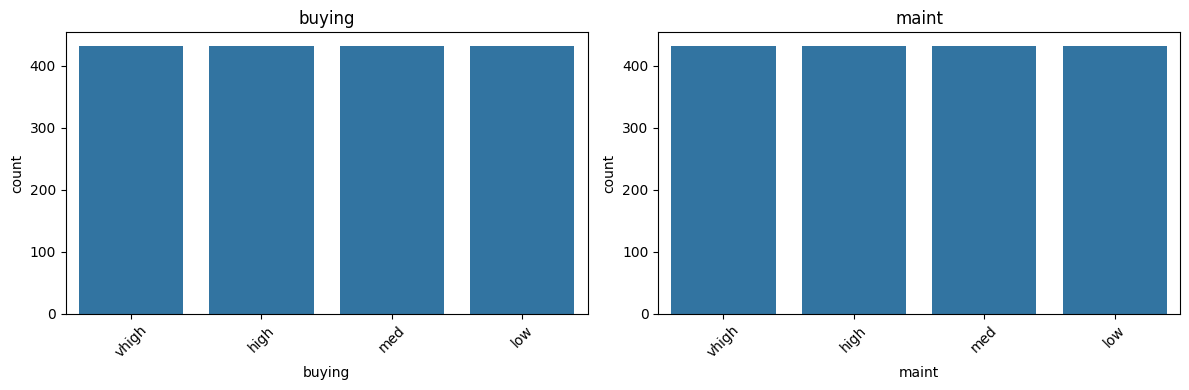

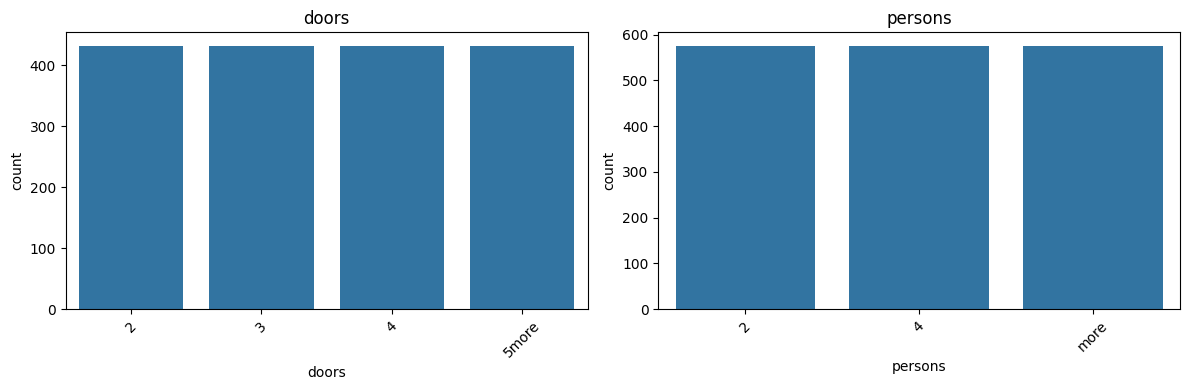

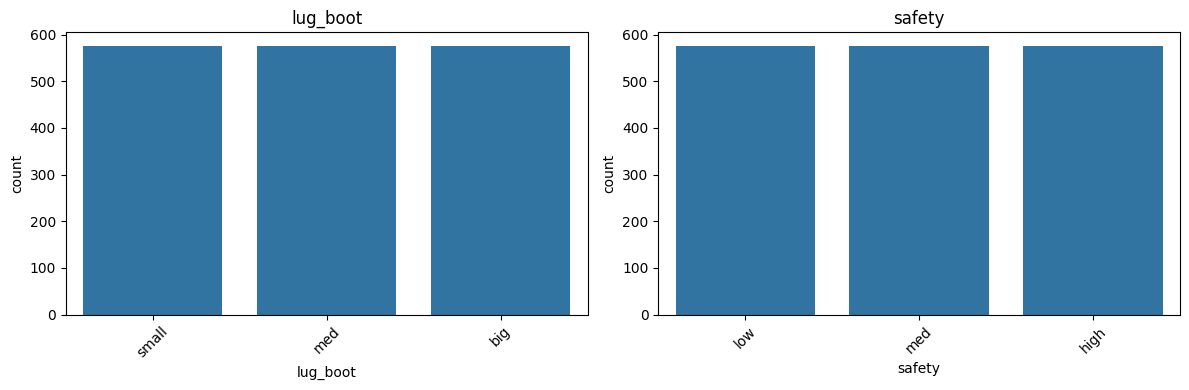

In [ ]:
#Gráfico de las variables
for i in range(0, len(X.columns), 2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for j, columna in enumerate(X.columns[i:i+2]):
        sns.countplot(x=columna, data=X, ax=axs[j])
        axs[j].set_title(columna)
        axs[j].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   1728 non-null   object
dtypes: object(1)
memory usage: 13.6+ KB
None


In [ ]:
print(y.describe())

        class
count    1728
unique      4
top     unacc
freq     1210


In [ ]:
print(y)

      class
0     unacc
1     unacc
2     unacc
3     unacc
4     unacc
...     ...
1723   good
1724  vgood
1725  unacc
1726   good
1727  vgood

[1728 rows x 1 columns]


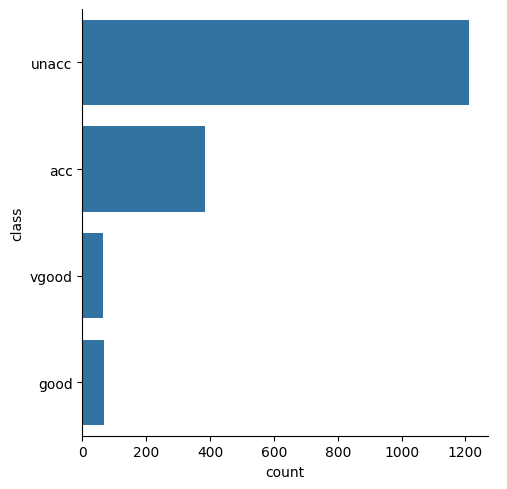

In [ ]:
sns.catplot(y='class', data=y, kind="count")

Una vez validada la información de las variables del dataset, no se identifican datos atipicos asi como valores nulos, por lo cual no se realizara ajustes sobre la data.

## Estandarización de las Variables a Numéricas

In [ ]:
X['buyingAjustado'] = X['buying'].map({'vhigh': 3, 'high':2, 'med':1, 'low':0}).astype(int)
X['maintAjustado'] = X['maint'].map({'vhigh': 3, 'high':2, 'med':1, 'low':0}).astype(int)
X['doorsAjustado'] = X['doors'].map({'5more': 3, '4':2, '3':1, '2':0}).astype(int)
X['personsAjustado'] = X['persons'].map({'more': 2, '4':1, '2':0}).astype(int)
X['lug_bootAjustado'] = X['lug_boot'].map({'big': 2, 'med':1, 'small':0}).astype(int)
X['safetyAjustado'] = X['safety'].map({'low': 0, 'med': 1, 'high': 2}).astype(int)

## Implementación del Modelo "Random Forest"

### Partición de la data en conjuntos de entrenamiento y pruebas

In [ ]:
X_ajustado = X.drop(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ajustado, y, test_size=0.2, stratify=y, random_state=1)

### Entrenamiento del Modelo

In [ ]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=0.12, verbose=2, bootstrap=True, random_state=1)
rf.fit(X_train, y_train)

<ipython-input-63-bd322786b93a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95

RandomForestClassifier(min_samples_leaf=0.12, random_state=1, verbose=2)

### Predicción del Modelo

In [ ]:
y_pred = rf.predict(X_test)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


In [ ]:
accuracy_score(y_test, y_pred)

0.6994219653179191

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[  0   0  77   0]
 [  0   0  14   0]
 [  0   0 242   0]
 [  0   0  13   0]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         acc       0.00      0.00      0.00        77
        good       0.00      0.00      0.00        14
       unacc       0.70      1.00      0.82       242
       vgood       0.00      0.00      0.00        13

    accuracy                           0.70       346
   macro avg       0.17      0.25      0.21       346
weighted avg       0.49      0.70      0.58       346



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


De acuerdo con el porcentaje de exactitud obtenido anteriormente, evidenciamos que el modelo obtuvo un total del 69.94% el cual posee el valor más bajo en comparación a los modelos evaluados anteriormente ("Decision Tree" y "K-Nearest Neighbor").

Por tal motivo, se procede a identificar las variables más influyentes al momento de generar la predicción sobre la variable objetivo.

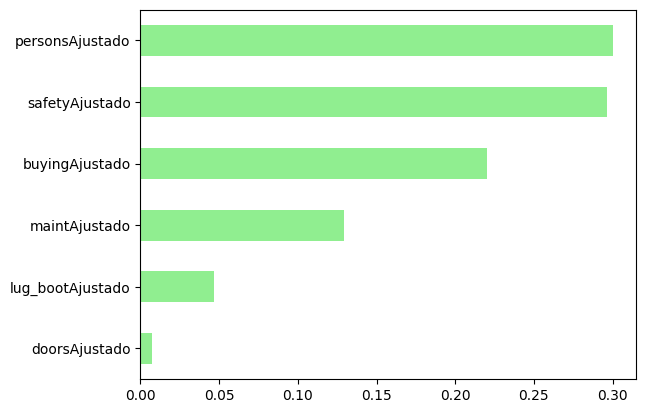

In [ ]:
importancia_rf = pd.Series(rf.feature_importances_, index=X_ajustado.columns)
sorted_importance_rf = importancia_rf.sort_values()
sorted_importance_rf.plot(kind = 'barh', color='Lightgreen')
plt.show()

In [ ]:
kf = KFold(n_splits = 5)
rf.fit(X_train, y_train)

score = rf.score(X_train, y_train)
print(score)

<ipython-input-75-eb79afb0272b>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


In [ ]:
scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
print (scores)
print (scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s



building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93

Se realiza una validación adicional del modelo evaluando cinco posibles escenarios, con el fin de identificar que al momento de utilizar conjuntos de datos de pruebas diferentes, el porcentaje de exactitud de estos modelos se encuentre próximo al obtenido inicialmente en el modelo principal. Una vez finalizada esta validación, se observa que el rango de exactitud de estos modelos es similar entre sí.

**Nota:** Se procederá a realizar un re-entrenamiento del modelo utilizando las varibles caracteristicas más sensibles al momento de generar la predicción de la variable objetivo `'class'`.